In [1]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")


import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import data_processing, compute_anomalies, extract_longitude_latitude, \
                            compute_forced_response, compute_variance, \
                            merge_runs,stack_runs, numpy_to_torch, standardize, build_training_and_test_sets

# Load data 

In [2]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)


###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]
time_period=33

## Data preprocessing

In [5]:
data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat, max_models=30)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# merge runs for each model
x, y, vars = stack_runs(x,y,vars, time_period,lon_size,lat_size)

/home/vcohen/cope/src/preprocessing.py:109: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/home/vcohen/cope/src/preprocessing.py:110: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/home/vcohen/cope/src/preprocessing.py:152: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/home/vcohen/cope/src/preprocessing.py:156: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


### Build training and test sets by removing a singe model m0

In [6]:
m0 = 'CMCC-CM2-SR5'

training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,vars,lon_size,lat_size,time_period=33)

### import ML algorithms 

In [7]:
from algorithms import ridge_regression, ridge_regression_low_rank, low_rank_projection, \
                        prediction, compute_gradient, train_robust_weights_model, compute_weights

from leave_one_out import leave_one_out_single, leave_one_out_procedure

## We would like to solve the problem with Trace norm regularization.
## $\min_{W}  \mu \log \left(\sum_{m} \exp(\frac{1}{\mu} \Vert Y^m - X^m W\Vert_F^2 ) \right) + \lambda \lVert W \rVert_*$
##
## Two options: 
### 1 - Solve the problem using variational formulation ($\eta$-trick)
### 2 - Solve the proble using accelerated gradient descent of Ji et al. 2009.

In [8]:
def sqrtm_evd(A):
    """
    Computes the square root of a symmetric positive definite matrix A using Eigen Decomposition.
    
    Parameters:
    - A (torch.Tensor): SPD matrix (n x n)
    
    Returns:
    - A_sqrt (torch.Tensor): Square root of A
    """
    assert A.shape[0] == A.shape[1], "Matrix must be square"
    
    # Eigenvalue decomposition
    eigvals, eigvecs = torch.linalg.eigh(A)  # A = U Λ U^T
    
    # Square root of eigenvalues
    sqrt_eigvals = torch.diag(torch.sqrt(eigvals))
    
    # Compute A^(1/2) = U sqrt(Λ) U^T
    A_sqrt = eigvecs @ sqrt_eigvals @ eigvecs.T
    return A_sqrt

In [27]:
##### Use variational formulation ###############
def compute_gradient_trace_norm(models,x,y,w,B,notnan_idx,lambda_=1.0,mu_=1.0, gamma_=1.0):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W + ridge regularization + trace norm rgularizer.

    Args:
        - x, y: input-output pair
        - w: regressor matrix
        - B: positive definite matrix used in the variation 
        
    Returns:
        - Gradient matrix: torch.tensor d x d
    """
    res = torch.zeros(len(models), w.shape[0], w.shape[0]).to(torch.float64)
    res_sumexp = torch.zeros(len(models)).to(torch.float64)

    print("Gradient start to be computed")
    for idx_m, m in enumerate(models):

        # compute -2X_{m,r}^T (Y_{m,r}^T - X_{m,r}^T W)
        res[idx_m][np.ix_(notnan_idx,notnan_idx)] = - 2*torch.mean(torch.bmm(torch.transpose(x[m][:,:,notnan_idx], 1,2) , \
                                                        y[m][:,:,notnan_idx] - x[m][:,:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)]),dim=0)

        # compute the exponential term
        res_sumexp[idx_m] = (1/mu_)*torch.mean(torch.norm(y[m][:,:,notnan_idx] - x[m][:,:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)],p='fro',dim=(1,2))**2)
            
    softmax = torch.nn.Softmax(dim=0)
    res_sumexp = softmax(res_sumexp)

    # compute gradient as sum (res * softmax)
    grad = torch.sum(torch.unsqueeze(torch.unsqueeze(res_sumexp,-1),-1) * res, dim=0)
    grad[np.ix_(notnan_idx,notnan_idx)] = grad[np.ix_(notnan_idx,notnan_idx)] + 2*lambda_* w[np.ix_(notnan_idx,notnan_idx)] + gamma_* torch.linalg.inv(B).T[np.ix_(notnan_idx,notnan_idx)] @ w[np.ix_(notnan_idx,notnan_idx)]
    
    
    # grad = grad + 2*lambda_* w + gamma_* torch.linalg.solve(B, torch.eye(B.shape[0]).to(torch.float64)).T @ w
    # grad = grad + 2*lambda_* w 
    # + gamma_* torch.linalg.pinv(B).T @ w
    
    return grad 

def train_robust_weights_trace_norm(models,x,y,notnan_idx,lambda_=1.0,mu_=1.0,gamma_=1.0,lr=0.1,nb_iterations=10):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W.

       Args:
            
       Returns:
    """
    w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    B = torch.eye(w.shape[0]).to(torch.float64)
    w_old = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)

    training_loss = torch.zeros(nb_iterations)
    
    # run a simple loop
    for it in range(nb_iterations):


        # accelerate gradient descent
        if it > 1:
            w_tmp = w + ((it-1)/(it+2)) * (w - w_old)
        else:
            w_tmp = w.detach()

        # save old parameter
        w_old = w.clone().detach()

        # compute gradient
        print(" Compute gradient ")
        
        grad = compute_gradient_trace_norm(models,x,y,w_tmp,B,notnan_idx,lambda_,mu_,gamma_)

        ######################### Update coordinates ###############
        # update the variable w
        w = w_tmp - lr * grad

        print(" Update intermediate variable ")
        # update variable B as square root (W W^T + gamma * I)^(1/2)
        B = sqrtm_evd(w @ w.T + 0.001 * torch.eye(w.shape[0]))

        # compute loss functon to check convergence 
        res = torch.zeros(len(models))
        
        print(" Compute loss function ")
        # compute loss functon to check convergence 
        res = torch.zeros(len(models))

        for idx_m, m in enumerate(models):

            # compute residuals
            res[idx_m] = torch.mean(torch.norm(y[m][:,:,notnan_idx] -x[m][:,:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx], p='fro',dim=(1,2))**2)
    
        obj = mu_*torch.logsumexp((1/mu_)* res,0)
        obj += lambda_*torch.norm(w,p='fro')**2
        # obj += 0.5*gamma_*torch.trace(w.T @ torch.linalg.pinv(B) @ w) 
        # obj += 0.5*gamma_* torch.trace(torch.linalg.pinv(B)) 
        # obj += 0.5*gamma_*0.1 *torch.trace(B) 
        

        print("Iteration ", it,  ": Loss function : ", obj.item())
        print("Rank of w: ", torch.linalg.matrix_rank(w))
        print("Nuclear norm of w: ", torch.norm(w, p='nuc'))
        
        training_loss[it] = obj.item()

    plt.close('all')
    plt.figure()
    plt.plot(range(nb_iterations),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.show()
    
    return w, training_loss


 Compute gradient 
Gradient start to be computed
 Update intermediate variable 
 Compute loss function 
Iteration  0 : Loss function :  70759.0
Rank of w:  tensor(65)
Nuclear norm of w:  tensor(0.0142, dtype=torch.float64)
 Compute gradient 
Gradient start to be computed
 Update intermediate variable 
 Compute loss function 
Iteration  1 : Loss function :  71368.21875
Rank of w:  tensor(64)
Nuclear norm of w:  tensor(0.0164, dtype=torch.float64)
 Compute gradient 
Gradient start to be computed
 Update intermediate variable 
 Compute loss function 
Iteration  2 : Loss function :  69759.1484375
Rank of w:  tensor(64)
Nuclear norm of w:  tensor(0.0658, dtype=torch.float64)
 Compute gradient 
Gradient start to be computed
 Update intermediate variable 
 Compute loss function 
Iteration  3 : Loss function :  74100.8828125
Rank of w:  tensor(65)
Nuclear norm of w:  tensor(0.1794, dtype=torch.float64)
 Compute gradient 
Gradient start to be computed
 Update intermediate variable 
 Compute los

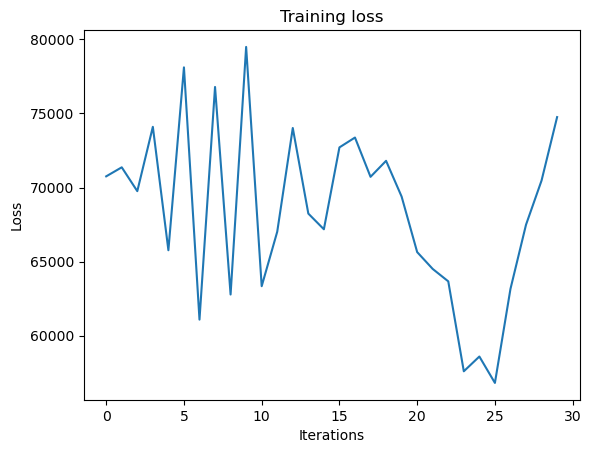

In [30]:
lambda_tmp = 100.0
mu_tmp = 1000.0

w_robust_ridge, training_loss = train_robust_weights_trace_norm(training_models,x_stacked,y_stacked,notnan_idx,lambda_=lambda_tmp,mu_=mu_tmp,gamma_=1000000.0,nb_iterations=30,lr =0.0000001)

In [40]:
##### code of paper of Ji et al. 2009 about accelerated gradient descent.

def singular_value_thresholding(D, tau):
    """Singular Value Thresholding (SVT) operator: D -> U * S_tau * V^T"""
    U, S, V = torch.svd(D)
    S_tau = torch.clamp(S - tau, min=0)  # Soft-thresholding on singular values
    return U @ torch.diag(S_tau) @ V.t()

def accelerated_trace_norm_minimization(models,x,y, lambda_=1.0,mu_=1.0,tau=1.0, max_iter=500, tol=1e-6):
    """
    Implements the Accelerated Gradient Method for Trace Norm Minimization
    from Ji & Ye (2009).
    
    Solves:
        min_W (1/2) ||W - M||_F^2 + tau ||W||_*

    Parameters:
    - M: Input matrix (torch.Tensor)
    - tau: Regularization parameter (controls nuclear norm weight)
    - max_iter: Maximum number of iterations
    - tol: Convergence tolerance

    Returns:
    - W_k: Optimized low-rank matrix
    """
    # Initialize variables
    Z_k = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)  # Z_k (momentum variable)
    W_k = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64) # W_k (solution)
    t_k = 1  # Momentum parameter

    for k in range(max_iter):
        W_k_prev = W_k.clone()  # Store previous iterate W_{k-1}

        # Gradient step: Compute G_k = Z_k - M
        # G_k = Z_k - M  # Gradient of (1/2) ||W - M||_F^2
        print("Compute gradient ")
        G_k = compute_gradient(models,x,y,W_k,notnan_idx,lambda_,mu_)


        print("Compute proximal step ")
        # Proximal step: Apply singular value thresholding (SVT)
        W_k = singular_value_thresholding(Z_k - G_k, tau)

        print("Momentum update ")
        # Momentum update
        t_k_next = 0.5 * (1 + torch.sqrt(1 + 4 * torch.tensor(t_k) ** 2))  # Compute t_{k+1}
        Z_k = W_k + ((t_k - 1) / t_k_next) * (W_k - W_k_prev)  # Update Z_k
        t_k = t_k_next  # Update t_k

        # print loss function
        # 0.5 * ||X - A||_F^2 + lambda * ||X||_*
        # loss =  0.5* torch.norm(W_k - M,p='fro')**2 + tau*torch.norm(W_k,p='nuc')

        # compute loss functon to check convergence 
        res = torch.zeros(len(models))
        
        for idx_m, m in enumerate(models):  
            
             # compute residuals
            res[idx_m] = torch.mean(torch.norm(y[m][:,:,notnan_idx] -x[m][:,:,notnan_idx] @ W_k[notnan_idx,:][:,notnan_idx], p='fro',dim=(1,2))**2)
                
            
        obj = mu_*torch.logsumexp((1/mu_)* res,0)
        obj += lambda_*torch.norm(W_k,p='fro')**2
        obj += tau_*torch.norm(W_k,p='nuc')
        loss = obj
        
        print("Iteration ", k, ": ", loss.item())

        # Convergence check
        if torch.norm(W_k - W_k_prev, p="fro") < tol:
            break

    return W_k


tau_ = 10000  # Regularization parameter
lambda_ = 100.0
mu_ = 1000.0
W_opt = accelerated_trace_norm_minimization(training_models,x_stacked,y_stacked, lambda_,mu_, tau_, max_iter=500, tol=1e-7)

Compute gradient 
Compute proximal step 
Momentum update 
Iteration  0 :  39652467671040.0
Compute gradient 
Compute proximal step 
Momentum update 


/tmp/ipykernel_42455/3353949157.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_k_next = 0.5 * (1 + torch.sqrt(1 + 4 * torch.tensor(t_k) ** 2))  # Compute t_{k+1}


Iteration  1 :  1.0877854027642322e+23
Compute gradient 
Compute proximal step 
Momentum update 
Iteration  2 :  2.9890104802734357e+32
Compute gradient 
Compute proximal step 


KeyboardInterrupt: 

In [ ]:
w_robust, training_loss = train_robust_weights_model(training_models,x,y,lon_size,lat_size,notnan_idx,rank=None,lambda_=1.0,mu_=1.0,lr=0.000001,nb_iterations=2)

In [ ]:
w_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
                                                              lon_size,lat_size,notnan_idx,nan_idx,\
                                                              lr=0.000001,nb_gradient_iterations=2,time_period=33,\
                                                              rank=5,lambda_=100.0,method='robust',mu_=1000.0,verbose=True)

## try to optimize with nuclear norm

In [ ]:
def train_robust_model_autograd(x,y,lon_size,lat_size,models,lambda_=1.0,mu_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - mu_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    w.requires_grad_(True) 

    # mat_eta = torch.eye(w.shape[0],w.shape[0]).to(torch.float64)
    # mat_eta.requires_grad_(True) 

    # define optimizer
    optimizer = torch.optim.Adam([w],lr=1e-5)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)
    
            
    # --- optimization loop ---                
    while (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
        res = torch.zeros(len(models))

        for idx_m, m in enumerate(models):  
            for idx_r, r in enumerate(x[m].keys()):
                res[idx_m] += torch.sum((y[m][r][:,notnan_idx] -x[m][r][:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx] )**2)
                
            res[idx_m] = res[idx_m]/len(x[m].keys())
            
        # obj = mu_*torch.logsumexp((1/mu_)* res,0)

        # Compute the nuclear norm (sum of singular values)
        U, S, V = torch.svd(w)  # Singular Value Decomposition

        # check if it works with simple linear regression
        obj = torch.sum(res)
        # obj += 0.5*lambda_*( torch.trace(w @ torch.linalg.inv(mat_eta) @ w.T) + torch.trace(mat_eta))
        obj +=  lambda_* S.sum()
        # obj += lambda_*torch.norm(w,p='nuc')

        
        #define loss function
        loss = obj

        # set the training loss
        training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward()               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step() 

        # print rank of matrix W
        print("Rank of the matrix : ", torch.linalg.matrix_rank(w))

        if(verbose==True):
            if(epoch % 1 == 0):
                print('Epoch ', epoch, 
                        ', loss=', training_loss[epoch].detach().item()
                        )
        criteria = loss
        epoch +=1
    
    plt.figure()
    plt.plot(range(nbEpochs),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()
    
    return w

In [ ]:
w = train_robust_model_autograd(x,y,lon_size,lat_size,training_models,lambda_=10000.0,mu_=10.0,nbEpochs=100,verbose=True)